## Семинар 2 "Распознавание рукописных цифр"

ФИО: Косарев Евгений Александрович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [16]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

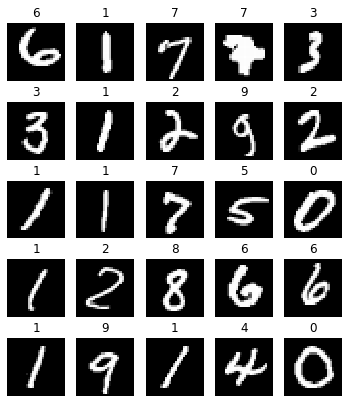

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [13]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            #train on train set
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            #get res on test
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [14]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.291/0.288	Accuracy: 0.923/0.923

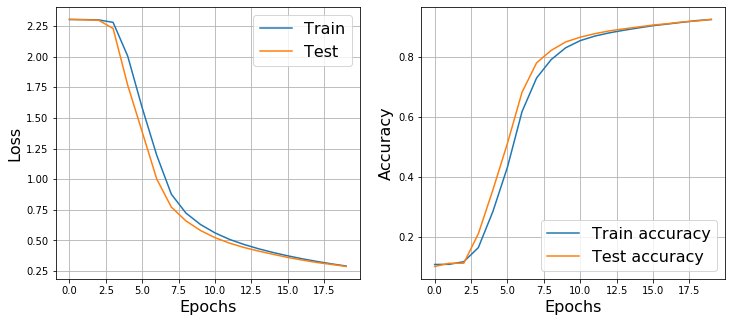

In [17]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [19]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [20]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(), # 28 * 28
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.037/0.083	Accuracy: 0.990/0.975

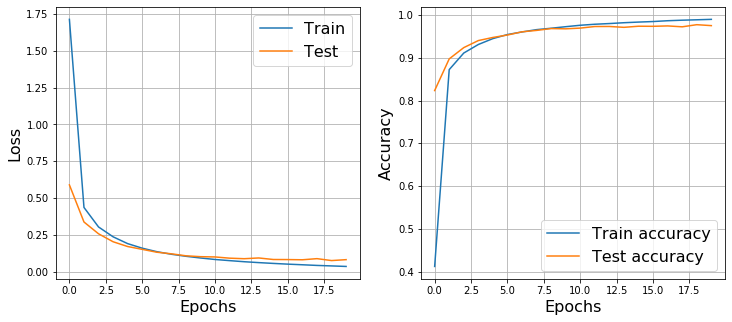

In [21]:
tr_s_ReLU, ts_s_ReLU, tr_ac_s_ReLU, ts_ac_s_ReLU = train(network, 20, 0.01)

In [22]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [23]:
network = NeuralNetwork([
    Linear(784, 100), ELU(), # 28 * 28
    Linear(100, 100), ELU(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.046/0.081	Accuracy: 0.987/0.975

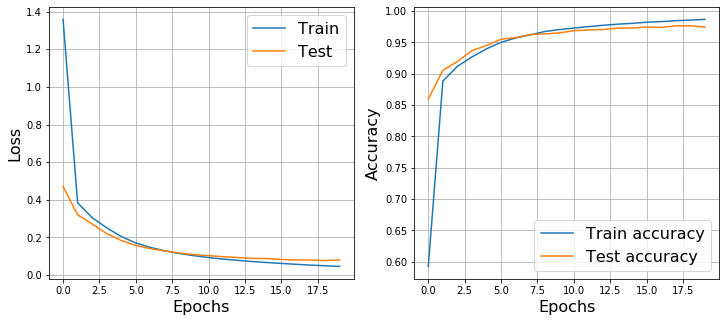

In [24]:
tr_s_ELU, ts_s_ELU, tr_ac_s_ELU, ts_ac_s_ELU = train(network, 20, 0.01)

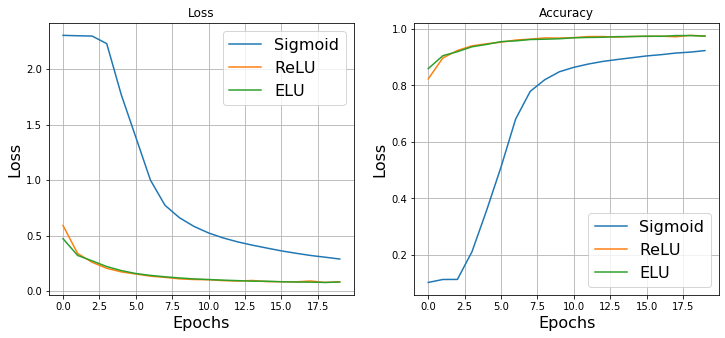

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_s_ReLU, label='ReLU')
plt.plot(ts_s_ELU, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_s_ReLU, label='ReLU')
plt.plot(ts_ac_s_ELU, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [61]:
wrong_answers = []
wrong_X = []
correct_y = []
predicted_y = []
logits = []

for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    
    y_predicted = network.forward(X)
    miss = list(y[y != np.argmax(y_predicted, axis = 1)])
    wrong_answers += miss
    
    for i in range(len(y_predicted)):
        if np.argmax(y_predicted[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(y_predicted[i]))
            logits.append(y_predicted[i][y[i]])

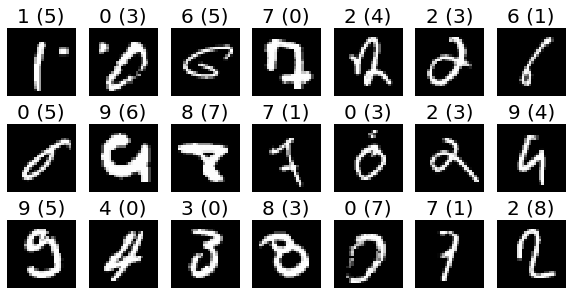

In [64]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{} ({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

In [65]:
nums, errs = np.unique(wrong_answers, return_counts=True)

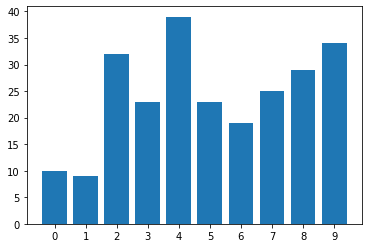

In [66]:
plt.bar(nums, errs)
plt.xticks(nums)
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [88]:
class Tanh:
    '''
    Tanh(x) = (1 - e ^ (-2x)) / (1 + e ^(-2x))
    '''
    
    def __init__(self):
        """:)"""

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return (1 - np.exp(-2*X)) / (1 + np.exp(-2*X))
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #X = self.X
        dydX = 4. / (np.exp(self.X) + np.exp(-self.X)) ** 2
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [52]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.031/0.079	Accuracy: 0.994/0.976

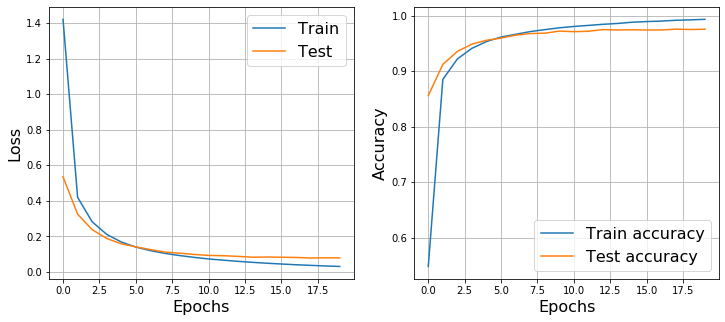

In [53]:
tr_Tanh, ts_Tanh, tr_ac_Tanh, ts_ac_Tanh = train(network, 20, 0.01)

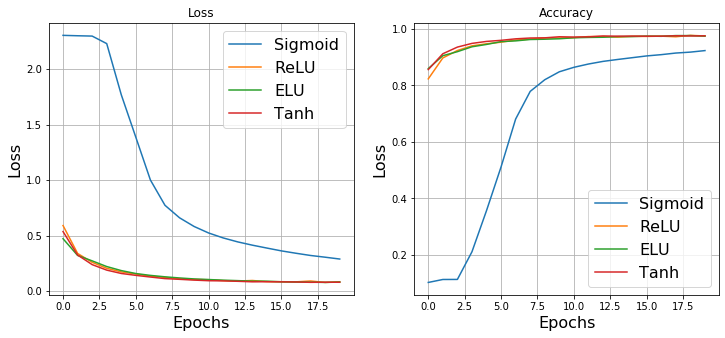

In [54]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_s_ReLU, label='ReLU')
plt.plot(ts_s_ELU, label='ELU')
plt.plot(ts_Tanh, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_s_ReLU, label='ReLU')
plt.plot(ts_ac_s_ELU, label='ELU')
plt.plot(ts_ac_Tanh, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [72]:
from skimage.transform import rotate

In [139]:
def train_with_aug(epochs, learning_rate, moves = 0, rotates = 0, noise = 0, activation = ReLU,
                   plot=True, loss=None):
    
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    network = NeuralNetwork([
        Linear(784, 100), activation, # 28 * 28
        Linear(100, 100), activation,
        Linear(100, 10)
    ])

    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            #train on train set
            for X, y in train_loader:
                
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                
                if noises > 0:
                    noise = np.zeros((noises, X.shape[1]))
                    for i in range(noises):
                        r = np.random.randint(low=0, high=32)
                        noise[i] = X[r] + np.random.random((28*28))
                        y = np.append(y, y[r])
                    X = np.vstack((X, noise))
                
                
                if moves > 0:
                    move = np.zeros((moves, X.shape[1]))
                    for i in range(moves):
                        r = np.random.randint(low=0, high=32)
                        move[i] = np.roll(X[r],
                                          np.random.randint(low=-3, high=3))
                        y = np.append(y, y[r])
                    X = np.vstack((X, move))

                if rotates > 0:
                    rot = np.zeros((rotates, X.shape[1]))
                    for i in range(rotates):
                        r = np.random.randint(low=0, high=32)
                        angle = -15
                        if i > rotates//2:
                            angle = 15
                        rot[i] = rotate(X[r].reshape(28, 28), angle).flatten()
                        y = np.append(y, y[r])
                    X = np.vstack((X, rot))
                
                
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            #get res on test
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
        print(f'noises = {noises}, moves = {moves}, rotates = {rotates}')
        
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [142]:
def test_aug(epochs, activation):
    params = []
    acc = []
    for noises in [0, 3]:
        for moves in [0, 3]:
            for rotates in [0, 3]:
                a, b, c, d = train_with_aug(epochs, 0.01, moves, rotates, noises, activation)
                print(f'loss = {b[-1]}, prec = {d[-1]}')
                acc.append(d)
                params.append((noises, moves, rotates))
    return acc, params

In [143]:
acc, params = test_aug(2, Tanh())

noises = 0, moves = 0, rotates = 0
loss = 0.42341741623366247, prec = 0.8827875399361023
noises = 0, moves = 0, rotates = 3
loss = 0.43663791490530746, prec = 0.8758985623003195
noises = 0, moves = 3, rotates = 0
loss = 0.4217495686090705, prec = 0.8820886581469649
noises = 0, moves = 3, rotates = 3
loss = 0.42954506440555784, prec = 0.8825878594249201
noises = 0, moves = 0, rotates = 0
loss = 0.43105431162578156, prec = 0.8813897763578274
noises = 0, moves = 0, rotates = 3
loss = 0.4126583056489826, prec = 0.8820886581469649
noises = 0, moves = 3, rotates = 0
loss = 0.4157011054205048, prec = 0.886082268370607
noises = 0, moves = 3, rotates = 3
loss = 0.3979354618161417, prec = 0.8923722044728435


Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [144]:
acc_ReLU, params_ReLU = test_aug(2, ReLU())

noises = 0, moves = 0, rotates = 0
loss = 0.353063705283998, prec = 0.8965654952076677
noises = 0, moves = 0, rotates = 3
loss = 0.34800155424437873, prec = 0.8995607028753994
noises = 0, moves = 3, rotates = 0
loss = 0.368468420265464, prec = 0.891473642172524
noises = 0, moves = 3, rotates = 3
loss = 0.3789411998479307, prec = 0.8918730031948882
noises = 0, moves = 0, rotates = 0
loss = 0.3874422422390198, prec = 0.8829872204472844
noises = 0, moves = 0, rotates = 3
loss = 0.37538770612272365, prec = 0.8901757188498403
noises = 0, moves = 3, rotates = 0
loss = 0.37189007452270023, prec = 0.8947683706070287
noises = 0, moves = 3, rotates = 3
loss = 0.3941661881585143, prec = 0.8832867412140575


In [147]:
acc_ELU, params_ELU = test_aug(2, ELU())

noises = 0, moves = 0, rotates = 0
loss = 0.34264609433158544, prec = 0.8989616613418531
noises = 0, moves = 0, rotates = 3
loss = 0.3311430669986676, prec = 0.9034544728434505
noises = 0, moves = 3, rotates = 0
loss = 0.3324754951569771, prec = 0.9055511182108626
noises = 0, moves = 3, rotates = 3
loss = 0.3438625418972327, prec = 0.9035543130990416
noises = 0, moves = 0, rotates = 0
loss = 0.32757774584830773, prec = 0.9028554313099042
noises = 0, moves = 0, rotates = 3
loss = 0.3376263781495461, prec = 0.9033546325878594
noises = 0, moves = 3, rotates = 0
loss = 0.32738911111117386, prec = 0.9073482428115016
noises = 0, moves = 3, rotates = 3
loss = 0.33609150652135034, prec = 0.9048522364217252


#### Итак, лучше всего ELU cо всеми типами агументации

In [148]:
a, b, c, d = train_with_aug(20, 0.01, 3, 3, 3, ELU())

noises = 0, moves = 3, rotates = 3


### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?